In [34]:
import os
import matplotlib.pyplot as plt
import numpy as np

from music21 import midi
from music21 import note, stream, duration
from music21 import converter

from models.MuseGAN import MuseGAN

from utils.loaders import load_music

from keras.models import load_model

In [36]:
# run params
SECTION = 'compose'
RUN_ID = '0016'
DATA_NAME = 'chorales'
FILENAME = 'Jsb16thSeparated.npz'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])


## data

In [37]:
BATCH_SIZE = 64
n_bars = 2
n_steps_per_bar = 16
n_pitches = 84
n_tracks = 4

data_binary, data_ints, raw_data = load_music(DATA_NAME, FILENAME, n_bars, n_steps_per_bar)
# data_binary = np.squeeze(data_binary)

In [38]:
gan = MuseGAN(input_dim = data_binary.shape[1:]
        , critic_learning_rate = 0.001
        , generator_learning_rate = 0.001
        , optimiser = 'adam'
        , grad_weight = 10
        , z_dim = 32
        , batch_size = BATCH_SIZE
        , n_tracks = n_tracks
        , n_bars = n_bars
        , n_steps_per_bar = n_steps_per_bar
        , n_pitches = n_pitches
        )



In [39]:
gan.load_weights(RUN_FOLDER, None)

In [40]:
gan.generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
melody_input (InputLayer)       (None, 4, 32)        0                                            
__________________________________________________________________________________________________
chords_input (InputLayer)       (None, 32)           0                                            
__________________________________________________________________________________________________
lambda_21 (Lambda)              (None, 32)           0           melody_input[0][0]               
__________________________________________________________________________________________________
lambda_22 (Lambda)              (None, 32)           0           melody_input[0][0]               
__________________________________________________________________________________________________
lambda_23 

In [41]:
gan.critic.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
critic_input (InputLayer)    (None, 2, 16, 84, 4)      0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 1, 16, 84, 128)    1152      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 1, 16, 84, 128)    0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 1, 16, 84, 128)    16512     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 1, 16, 84, 128)    0         
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 1, 16, 7, 128)     196736    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 1, 16, 7, 128)     0         
__________

# view sample score

In [42]:
chords_noise = np.random.normal(0, 1, (1, gan.z_dim))
style_noise = np.random.normal(0, 1, (1, gan.z_dim))
melody_noise = np.random.normal(0, 1, (1, gan.n_tracks, gan.z_dim))
groove_noise = np.random.normal(0, 1, (1, gan.n_tracks, gan.z_dim))

In [43]:
gen_scores = gan.generator.predict([chords_noise, style_noise, melody_noise, groove_noise])

In [44]:

np.argmax(gen_scores[0,0,0:4,:,3], axis = 1)

array([50, 46, 50, 45], dtype=int64)

In [45]:
gen_scores[0,0,0:4,60,3] = 0.02347812

In [46]:
filename = 'example'
gan.notes_to_midi(RUN_FOLDER, gen_scores, filename)
gen_score = converter.parse(os.path.join(RUN_FOLDER, 'samples/{}.midi'.format(filename)))
gen_score.show()

OSError: [WinError 123] The filename, directory name, or volume label syntax is incorrect: 'D:\\devi\\Repos\\GDL_code\\C:\\Program Files (x86)\\MuseScore 2\\MuseScore.exe'

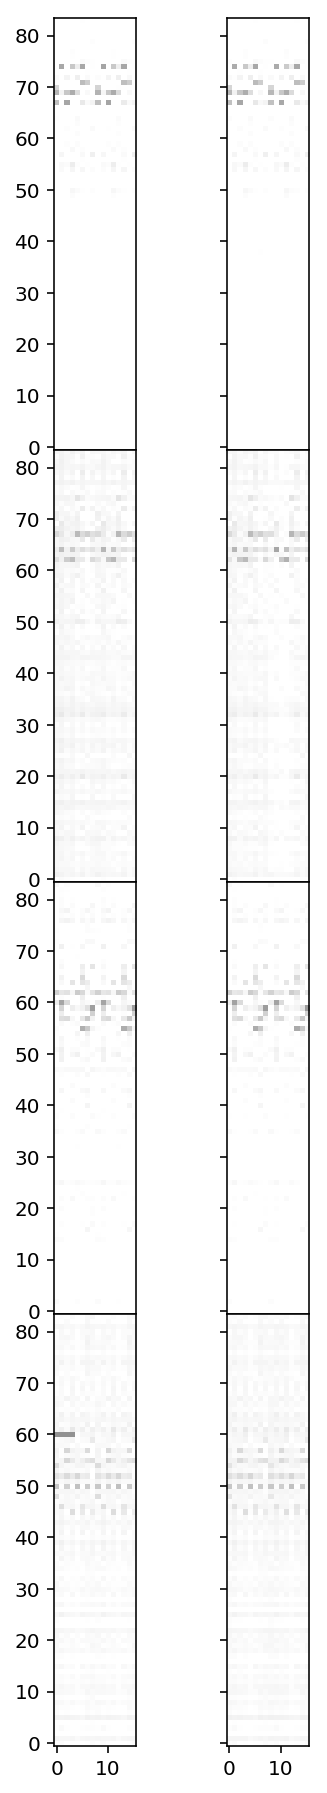

In [47]:
gan.draw_score(gen_scores, 0)

# find the closest match

In [15]:
def find_closest(data_binary, score):
    current_dist = 99999999
    current_i = -1
    for i, d in enumerate(data_binary):
        dist = np.sqrt(np.sum(pow((d - score),2)))
        if dist < current_dist:
            current_i = i
            current_dist = dist
        
    return current_i
    

In [16]:
closest_idx = find_closest(data_binary, gen_scores[0])
closest_data = data_binary[[closest_idx]]
print(closest_idx)

113


In [17]:
filename = 'closest'
gan.notes_to_midi(RUN_FOLDER, closest_data,filename)
closest_score = converter.parse(os.path.join(RUN_FOLDER, 'samples/{}.midi'.format(filename)))
print('original')
gen_score.show()
print('closest')
closest_score.show()


original


OSError: [WinError 123] The filename, directory name, or volume label syntax is incorrect: 'D:\\devi\\Repos\\GDL_code\\C:\\Program Files (x86)\\MuseScore 2\\MuseScore.exe'

# changing the chords noise

In [18]:
chords_noise_2 = 5 * np.ones((1, gan.z_dim))

In [19]:
chords_scores = gan.generator.predict([chords_noise_2, style_noise, melody_noise, groove_noise])

In [20]:
filename = 'changing_chords'
gan.notes_to_midi(RUN_FOLDER, chords_scores, filename)
chords_score = converter.parse(os.path.join(RUN_FOLDER, 'samples/{}.midi'.format(filename)))
print('original')
gen_score.show()
print('chords noise changed')
chords_score.show()

original


OSError: [WinError 123] The filename, directory name, or volume label syntax is incorrect: 'D:\\devi\\Repos\\GDL_code\\C:\\Program Files (x86)\\MuseScore 2\\MuseScore.exe'

# changing the style noise

In [21]:
style_noise_2 = 5 * np.ones((1, gan.z_dim))

In [22]:
style_scores = gan.generator.predict([chords_noise, style_noise_2, melody_noise, groove_noise])

In [23]:
filename = 'changing_style'
gan.notes_to_midi(RUN_FOLDER, style_scores, filename)
style_score = converter.parse(os.path.join(RUN_FOLDER, 'samples/{}.midi'.format(filename)))
print('original')
gen_score.show()
print('style noise changed')
style_score.show()

original


OSError: [WinError 123] The filename, directory name, or volume label syntax is incorrect: 'D:\\devi\\Repos\\GDL_code\\C:\\Program Files (x86)\\MuseScore 2\\MuseScore.exe'

# changing the melody noise

In [24]:
melody_noise_2 = np.copy(melody_noise)
melody_noise_2[0,0,:] = 5 * np.ones(gan.z_dim) 

In [25]:
melody_scores = gan.generator.predict([chords_noise, style_noise, melody_noise_2, groove_noise])

In [26]:
filename = 'changing_melody'
gan.notes_to_midi(RUN_FOLDER, melody_scores, filename)
melody_score = converter.parse(os.path.join(RUN_FOLDER, 'samples/{}.midi'.format(filename)))
print('original')
gen_score.show()
print('melody noise changed')
melody_score.show()

original


OSError: [WinError 123] The filename, directory name, or volume label syntax is incorrect: 'D:\\devi\\Repos\\GDL_code\\C:\\Program Files (x86)\\MuseScore 2\\MuseScore.exe'

# changing the groove noise

In [27]:
groove_noise_2 = np.copy(groove_noise)
groove_noise_2[0,3,:] = 5 * np.ones(gan.z_dim)

In [28]:
groove_scores = gan.generator.predict([chords_noise, style_noise, melody_noise, groove_noise_2])

In [29]:
filename = 'changing_groove'
gan.notes_to_midi(RUN_FOLDER, groove_scores, filename)
groove_score = converter.parse(os.path.join(RUN_FOLDER, 'samples/{}.midi'.format(filename)))
print('original')
gen_score.show()
print('groove noise changed')
groove_score.show()

original


OSError: [WinError 123] The filename, directory name, or volume label syntax is incorrect: 'D:\\devi\\Repos\\GDL_code\\C:\\Program Files (x86)\\MuseScore 2\\MuseScore.exe'